In [2]:
from pathlib import Path
from time import time
import argparse
import shutil
import random

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import numpy as np

from Bio.PDB import PDBParser
from Bio.PDB.Polypeptide import three_to_one, is_aa
from rdkit import Chem
from scipy.ndimage import gaussian_filter

import torch

from analysis.molecule_builder import build_molecule
from analysis.metrics import rdmol_to_smiles
import constants
from constants import covalent_radii, dataset_params


def process_ligand_and_pocket(pdbfile, sdffile,
                              atom_dict, dist_cutoff, ca_only):
    pdb_struct = PDBParser(QUIET=True).get_structure('', pdbfile)

    try:
        ligand = Chem.SDMolSupplier(str(sdffile))[0]
    except:
        raise Exception(f'cannot read sdf mol ({sdffile})')

    # remove H atoms if not in atom_dict, other atom types that aren't allowed
    # should stay so that the entire ligand can be removed from the dataset
    lig_atoms = [a.GetSymbol() for a in ligand.GetAtoms()
                 if (a.GetSymbol().capitalize() in atom_dict or a.element != 'H')]
    lig_coords = np.array([list(ligand.GetConformer(0).GetAtomPosition(idx))
                           for idx in range(ligand.GetNumAtoms())])

    try:
        lig_one_hot = np.stack([
            np.eye(1, len(atom_dict), atom_dict[a.capitalize()]).squeeze()
            for a in lig_atoms
        ])
    except KeyError as e:
        raise KeyError(
            f'{e} not in atom dict ({sdffile})')

    # Find interacting pocket residues based on distance cutoff
    pocket_residues = []
    for residue in pdb_struct[0].get_residues():
        res_coords = np.array([a.get_coord() for a in residue.get_atoms()])
        if is_aa(residue.get_resname(), standard=True) and \
                (((res_coords[:, None, :] - lig_coords[None, :, :]) ** 2).sum(
                    -1) ** 0.5).min() < dist_cutoff:
            pocket_residues.append(residue)

    pocket_ids = [f'{res.parent.id}:{res.id[1]}' for res in pocket_residues]
    ligand_data = {
        'lig_coords': lig_coords,
        'lig_one_hot': lig_one_hot,
    }
    if ca_only:
        try:
            pocket_one_hot = []
            full_coords = []
            for res in pocket_residues:
                for atom in res.get_atoms():
                    if atom.name == 'CA':
                        pocket_one_hot.append(np.eye(1, len(amino_acid_dict),
                                                     amino_acid_dict[three_to_one(res.get_resname())]).squeeze())
                        full_coords.append(atom.coord)
            pocket_one_hot = np.stack(pocket_one_hot)
            full_coords = np.stack(full_coords)
        except KeyError as e:
            raise KeyError(
                f'{e} not in amino acid dict ({pdbfile}, {sdffile})')
        pocket_data = {
            'pocket_coords': full_coords,
            'pocket_one_hot': pocket_one_hot,
            'pocket_ids': pocket_ids
        }
    else:
        full_atoms = np.concatenate(
            [np.array([atom.element for atom in res.get_atoms()])
             for res in pocket_residues], axis=0)
        full_coords = np.concatenate(
            [np.array([atom.coord for atom in res.get_atoms()])
             for res in pocket_residues], axis=0)
        try:
            pocket_one_hot = []
            for a in full_atoms:
                if a in amino_acid_dict:
                    atom = np.eye(1, len(amino_acid_dict),
                                  amino_acid_dict[a.capitalize()]).squeeze()
                elif a != 'H':
                    atom = np.eye(1, len(amino_acid_dict),
                                  len(amino_acid_dict)).squeeze()
                pocket_one_hot.append(atom)
            pocket_one_hot = np.stack(pocket_one_hot)
        except KeyError as e:
            raise KeyError(
                f'{e} not in atom dict ({pdbfile})')
        pocket_data = {
            'pocket_coords': full_coords,
            'pocket_one_hot': pocket_one_hot,
            'pocket_ids': pocket_ids
        }
    return ligand_data, pocket_data


Distance matrix shape: torch.Size([26, 26])
RBF output shape: torch.Size([26, 26, 32])


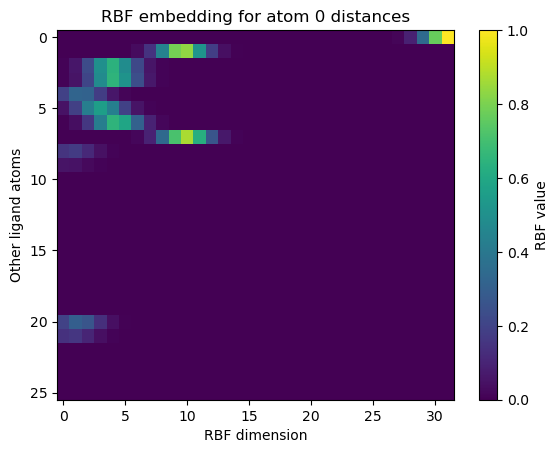

In [3]:
from rdkit import Chem
import numpy as np
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt

# ==== Định nghĩa lại các lớp cần thiết ====
class CosineCutoff(nn.Module):
    def __init__(self, cutoff):
        super(CosineCutoff, self).__init__()
        self.cutoff = cutoff
    def forward(self, distances):
        cutoffs = 0.5 * (torch.cos(distances * math.pi / self.cutoff) + 1.0)
        cutoffs = cutoffs * (distances < self.cutoff).to(cutoffs.dtype)
        return cutoffs

class ExpNormalSmearing(nn.Module):
    def __init__(self, cutoff=5.0, num_rbf=20, trainable=False):
        super(ExpNormalSmearing, self).__init__()
        self.cutoff = cutoff
        self.num_rbf = num_rbf
        self.trainable = trainable
        self.cutoff_fn = CosineCutoff(cutoff)
        self.alpha = 5.0 / cutoff
        means, betas = self._initial_params()
        if trainable:
            self.register_parameter("means", nn.Parameter(means))
            self.register_parameter("betas", nn.Parameter(betas))
        else:
            self.register_buffer("means", means)
            self.register_buffer("betas", betas)
    def _initial_params(self):
        start_value = torch.exp(torch.scalar_tensor(-self.cutoff))
        means = torch.linspace(start_value, 1, self.num_rbf)
        betas = torch.tensor([(2 / self.num_rbf * (1 - start_value)) ** -2] * self.num_rbf)
        return means, betas
    def forward(self, dist):
        dist = dist.unsqueeze(-1)
        return self.cutoff_fn(dist) * torch.exp(-self.betas * (torch.exp(self.alpha * (-dist)) - self.means) ** 2)

if __name__ == "__main__":
    pdb_path = r"data\1A1C_MALDO_2_433_0\1m4n_A_rec_1m7y_ppg_lig_tt_min_0_pocket10.pdb"   
    sdf_path = r"data\1A1C_MALDO_2_433_0\1m4n_A_rec_1m7y_ppg_lig_tt_min_0.sdf"     

    dataset_info = dataset_params['crossdock']
    amino_acid_dict = dataset_info['aa_encoder']
    atom_dict = dataset_info['atom_encoder']
    atom_decoder = dataset_info['atom_decoder']

    lig_data, poc_data = process_ligand_and_pocket(
        pdb_path, sdf_path, atom_dict, dist_cutoff=6.0, ca_only=True
    )

    lig_coords = torch.tensor(lig_data['lig_coords'], dtype=torch.float64)
    pocket_coords = torch.tensor(poc_data['pocket_coords'], dtype=torch.float64)

    # Compute ligand–ligand pairwise distance
    dist = torch.cdist(lig_coords, lig_coords)
    print(f"Distance matrix shape: {dist.shape}")

    # Pass through RBF
    rbf_layer = ExpNormalSmearing(cutoff=6.0, num_rbf=32)
    rbf_output = rbf_layer(dist)
    print(f"RBF output shape: {rbf_output.shape}")

    # Example visualization for first ligand atom
    plt.imshow(rbf_output[0].detach().numpy(), aspect='auto', cmap='viridis')
    plt.colorbar(label='RBF value')
    plt.title("RBF embedding for atom 0 distances")
    plt.xlabel("RBF dimension")
    plt.ylabel("Other ligand atoms")
    plt.show()


In [4]:
if __name__ == "__main__":
    pdb_path = r"data\1B57_HUMAN_25_300_0\3upr_C_rec_3upr_1kx_lig_tt_docked_3_pocket10.pdb"   
    sdf_path = r"data\1B57_HUMAN_25_300_0\3upr_C_rec_3upr_1kx_lig_tt_docked_3.sdf"     

    dataset_info = dataset_params['crossdock']
    amino_acid_dict = dataset_info['aa_encoder']
    atom_dict = dataset_info['atom_encoder']
    atom_decoder = dataset_info['atom_decoder']

    lig_data, poc_data = process_ligand_and_pocket(
        pdb_path, sdf_path, atom_dict, dist_cutoff=6.0, ca_only=True
    )

In [5]:
poc_data

{'pocket_coords': array([[ -5.186, -21.961, -40.769],
        [-13.509, -25.861, -41.57 ],
        [-13.373, -20.89 , -45.005],
        [-15.864, -17.012, -46.011],
        [ -7.434, -15.861, -45.299],
        [ -6.26 , -17.397, -38.901],
        [ -4.254, -18.012, -35.74 ],
        [ -5.856, -19.227, -32.533],
        [ -7.957, -15.633, -32.081],
        [ -6.804, -13.195, -34.757],
        [ -6.852, -13.177, -38.534],
        [ -5.538, -11.622, -41.712],
        [ -8.599,  -8.379, -40.289],
        [-10.153,  -9.125, -36.888],
        [ -8.666, -10.079, -33.526],
        [-10.155, -11.378, -30.292],
        [-13.094,  -7.565, -30.992],
        [-17.94 ,  -9.18 , -39.311],
        [-19.94 , -11.863, -34.229],
        [-19.094, -15.751, -30.874],
        [-14.2  , -18.88 , -28.346],
        [ -5.049, -16.467, -42.392],
        [-15.012, -11.449, -48.05 ],
        [ -6.977, -11.001, -45.152]], dtype=float32),
 'pocket_one_hot': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [6]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from e3nn.o3 import spherical_harmonics, TensorProduct, Irreps
import itertools

def visualize_e3nn_on_ligand(lig_coords, lig_atom_ids, atom_decoder, colors_dic, cutoff=3.0):
    """
    Hiển thị phân tử 3D với màu nguyên tử và invariant e3nn
    lig_coords: Tensor [N, 3]
    lig_atom_ids: list[int] (theo thứ tự atom_decoder)
    """
    n_atoms = lig_coords.shape[0]

    # Ghép mỗi atom ID với màu tương ứng
    atom_colors = [colors_dic[idx] for idx in lig_atom_ids]

    # Tạo danh sách các cặp gần nhau (r < cutoff)
    pairs = [(i, j) for i, j in itertools.combinations(range(n_atoms), 2)
             if torch.norm(lig_coords[i] - lig_coords[j]) < cutoff]

    # TensorProduct invariant: (l1=1, l2=1 → l_out=0)
    irreps_in = Irreps("1x1o")
    irreps_out = Irreps("1x0e")
    tp = TensorProduct(irreps_in, irreps_in, irreps_out,
                       instructions=[(0, 0, 0, "uvw", True, 1.0)])

    # --- Bắt đầu vẽ 3D
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.set_title("Biểu diễn hướng e3nn với tô màu nguyên tử")

    # Vẽ nguyên tử với màu riêng
    for i, color in enumerate(atom_colors):
        ax.scatter(lig_coords[i, 0], lig_coords[i, 1], lig_coords[i, 2],
                   color=color, s=120, edgecolor="k")
        ax.text(lig_coords[i, 0], lig_coords[i, 1], lig_coords[i, 2],
                atom_decoder[lig_atom_ids[i]], color="black", fontsize=9)

    # Vẽ vector liên kết & giá trị invariant
    for (i, j) in pairs:
        r_ij = (lig_coords[j] - lig_coords[i]).to(torch.float32)
        Y_ij = spherical_harmonics(1, r_ij, normalize=True, normalization='component')

        k = (j + 1) % n_atoms
        r_ik = (lig_coords[k] - lig_coords[i]).to(torch.float32)
        Y_ik = spherical_harmonics(1, r_ik, normalize=True, normalization='component')

        invariant = tp(Y_ij, Y_ik).item()
        mid = (lig_coords[i] + lig_coords[j]) / 2

        ax.plot([lig_coords[i, 0], lig_coords[j, 0]],
                [lig_coords[i, 1], lig_coords[j, 1]],
                [lig_coords[i, 2], lig_coords[j, 2]],
                color="gray", alpha=0.5, lw=1)

        ax.text(mid[0], mid[1], mid[2],
                f"{invariant:.2f}", color="black", fontsize=7)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()


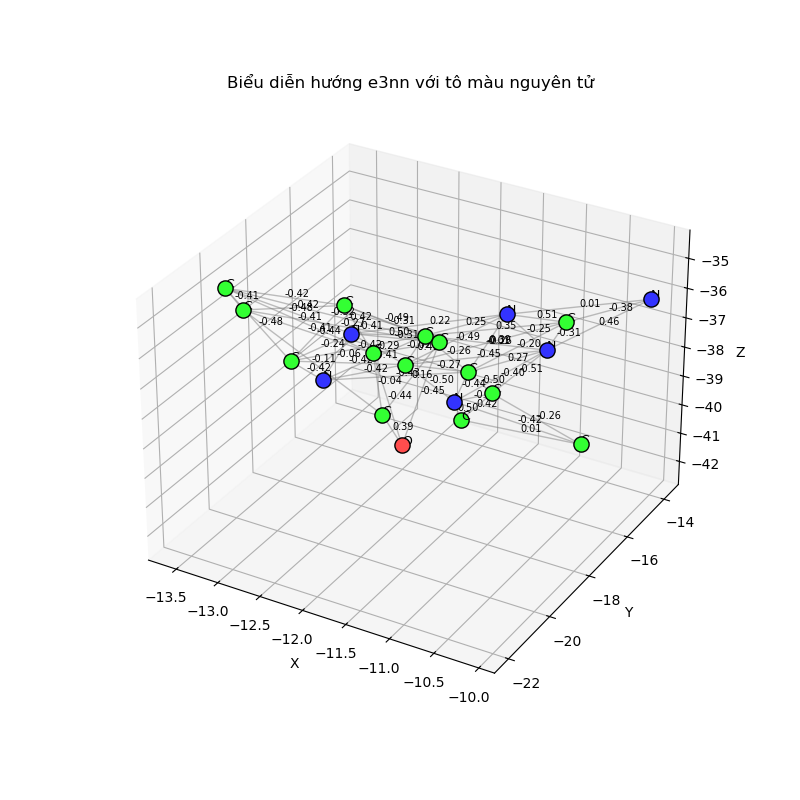

In [7]:
if __name__ == "__main__":
    dataset_info = dataset_params['crossdock']
    atom_decoder = dataset_info['atom_decoder']
    colors_dic = dataset_info['colors_dic']

    lig_data, poc_data = process_ligand_and_pocket(
        pdb_path, sdf_path, dataset_info['atom_encoder'], dist_cutoff=6.0, ca_only=True
    )

    lig_coords = torch.tensor(lig_data['lig_coords'], dtype=torch.float32)

    # 🧩 Chuyển one-hot thành chỉ số nguyên tử
    lig_atom_ids = torch.argmax(torch.tensor(lig_data['lig_one_hot']), dim=1).tolist()
    %matplotlib widget
    visualize_e3nn_on_ligand(
        lig_coords=lig_coords,
        lig_atom_ids=lig_atom_ids,
        atom_decoder=atom_decoder,
        colors_dic=colors_dic,
        cutoff=3.0
    )


In [8]:
print(lig_data.keys())


dict_keys(['lig_coords', 'lig_one_hot'])
